In [1]:
%cd /workspace/kbqa

/workspace/kbqa


In [19]:
from tqdm import tqdm
tqdm.pandas()
from kbqa.reranking.feature_extraction import *
import pathlib
import json
import csv
from tqdm import tqdm
import argparse
import pandas as pd
from kbqa.wikidata.wikidata_subgraphs_retriever import SubgraphNodeType
import re
from kbqa.reranking.get_sitelinks import *
from sklearn.feature_extraction.text import TfidfVectorizer
from kbqa.caches.genre import GENREWikidataEntityesCache
from sklearn.utils import class_weight
from kbqa.wikidata import (
    WikidataEntityToLabel,
    WikidataShortestPathCache,
    WikidataLabelToEntity,
    WikidataRedirectsCache,
)
import nltk
from nltk.corpus import stopwords
from joblib import Memory

from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score, accuracy_score

In [4]:
df = pd.read_json('/workspace/subgraphs/mintaka_train_labeled.jsonl', lines=True)
df_val = pd.read_json('/workspace/subgraphs/mintaka_validation_labeled.jsonl', lines=True)
df_test = pd.read_json('/workspace/subgraphs/mintaka_test_labeled.jsonl', lines=True)

concatenated_df = pd.concat([df, df_val, df_test])

In [5]:
entity2label = WikidataEntityToLabel()
memory = Memory('/tmp/cache', verbose=0)

@memory.cache
def get_label(entity):
    labels = []
    for ent in entity:
        labels.append(entity2label.get_label(f"{ent}"))
    return labels

In [6]:
labels = concatenated_df.answerEntity.progress_apply(get_label)

100%|██████████| 140644/140644 [00:41<00:00, 3377.20it/s]


In [7]:
def join_strings(lst):
    try:
        return ' '.join(lst)
    except:
        return ''

In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
concatenated_df['answer'] = labels
concatenated_df['answer'] = concatenated_df['answer'].progress_apply(join_strings)
concatenated_df['combined'] = (concatenated_df['question'].str.lower() + ', ' + concatenated_df['answer'].str.lower()).apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

100%|██████████| 140644/140644 [00:00<00:00, 688227.28it/s]


In [10]:
# create a TfidfVectorizer object
vectorizer = TfidfVectorizer(max_features = 2000)
# fit and transform the vectorizer to the sentences column
vectors = vectorizer.fit_transform(concatenated_df['combined'])
# add the vectors as a new column to the original dataframe
concatenated_df['tfidf_vectors'] = list(vectors.toarray())

In [11]:
#Sanity check

bag_of_words = vectorizer.get_feature_names_out()
count = 0
for ans in concatenated_df['answer'].tolist():
    for a in ans.split():
        if a in bag_of_words:
            count+=1
        
print(count)

52656


In [12]:
concatenated_df["label"] = concatenated_df["answerEntity"] == concatenated_df["groundTruthAnswerEntity"]
concatenated_df["label"] = concatenated_df["label"].astype(int)

df = concatenated_df.iloc[:len(df)]
df_val = concatenated_df.iloc[len(df):len(df)+len(df_val)]
df_test = concatenated_df.iloc[len(df)+len(df_val):]

In [13]:
# Getting data ready
X_train, y_train = df['tfidf_vectors'].to_frame(), df['label']
X_val, y_val = df_val['tfidf_vectors'].to_frame(), df_val['label']
X_test, y_test = df_test['tfidf_vectors'].to_frame(), df_test['label']


In [14]:
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)
print(class_weights)

[0.54676014 5.84643368]


In [18]:
# Convert tfidf_vectors column to pandas DataFrame
X_train_df = pd.DataFrame(X_train['tfidf_vectors'].to_list())
X_val_df = pd.DataFrame(X_val['tfidf_vectors'].to_list())

# Select common features
common_features = set(X_train_df.columns).intersection(X_val_df.columns)
X_train_common = X_train_df[list(common_features)]
X_val_common = X_val_df[list(common_features)]

# Convert back to numpy arrays
X_train_np = X_train_common.values
X_val_np = X_val_common.values
X_test_np = np.array([np.array(x) for x in X_test['tfidf_vectors']])

In [20]:
# Initialize model with cat_vars
rf = CatBoostClassifier(
                   loss_function = "Logloss",
                   eval_metric = "AUC",
                   class_weights=class_weights,
                   iterations=2000,
                   l2_leaf_reg=5,
                   early_stopping_rounds=50
                   )

# Fit & Predict
rf.fit(X_train_np, y_train.values, plot=True, eval_set=(X_val_np, y_val.values))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6059529	best: 0.6059529 (0)	total: 146ms	remaining: 4m 51s
1:	test: 0.6081238	best: 0.6081238 (1)	total: 185ms	remaining: 3m 5s
2:	test: 0.6088488	best: 0.6088488 (2)	total: 226ms	remaining: 2m 30s
3:	test: 0.6090950	best: 0.6090950 (3)	total: 267ms	remaining: 2m 13s
4:	test: 0.6092898	best: 0.6092898 (4)	total: 306ms	remaining: 2m 2s
5:	test: 0.6123118	best: 0.6123118 (5)	total: 346ms	remaining: 1m 54s
6:	test: 0.6168421	best: 0.6168421 (6)	total: 385ms	remaining: 1m 49s
7:	test: 0.6247190	best: 0.6247190 (7)	total: 427ms	remaining: 1m 46s
8:	test: 0.6276526	best: 0.6276526 (8)	total: 466ms	remaining: 1m 43s
9:	test: 0.6274810	best: 0.6276526 (8)	total: 505ms	remaining: 1m 40s
10:	test: 0.6327440	best: 0.6327440 (10)	total: 545ms	remaining: 1m 38s
11:	test: 0.6371962	best: 0.6371962 (11)	total: 587ms	remaining: 1m 37s
12:	test: 0.6369178	best: 0.6371962 (11)	total: 626ms	remaining: 1m 35s
13:	test: 0.6385141	best: 0.6385141 (13)	total: 666ms	remaining: 1m 34s
14:	test: 0.63

In [21]:
# Predict probabilities
y_pred_proba = rf.predict_proba(X_test_np)[:, 1]  # Probability of positive class
# Predict classes
y_pred = rf.predict(X_test_np)

In [22]:
# Calculate metrics
f1 = f1_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("F1 score: {:.3f}".format(f1))
print("Balanced accuracy: {:.3f}".format(balanced_accuracy))
print("Confusion matrix:")
print(confusion_matrix)
print("Accuracy score: {:.3f}".format(accuracy))
print("Predicted probabilities:")
print(y_pred_proba)

F1 score: 0.251
Balanced accuracy: 0.688
Confusion matrix:
[[15147 10795]
 [  493  1890]]
Accuracy score: 0.601
Predicted probabilities:
[0.47378786 0.52631814 0.53325401 ... 0.31022914 0.53750151 0.42357534]


In [23]:
def graph_data(graph):
    
    try:
    
        subgraph = nx.readwrite.json_graph.node_link_graph(graph)
        adj_mat = nx.adjacency_matrix(
            subgraph, nodelist=None, dtype=None, weight="weight"
        )
        g = adj_mat.toarray()
        G = nx.from_numpy_array(g)
        N_TRIANGLES = number_of_triangles(subgraph, True)
        n_nodes, n_edges = nodes_and_edges(subgraph)
        
        for item in graph['nodes']:
            if item['type'] == 'ANSWER_CANDIDATE_ENTITY':
            
                candidate = item['id'] 
                
        
        try:
            f_katz_centrality = katz_centrality(subgraph)
            N_KATZ_CENTRALITY = 0
            for key, value in f_katz_centrality.items():
                if key == candidate:
                    N_KATZ_CENTRALITY += value
        except:
            N_KATZ_CENTRALITY = 0
        
        try:
            f_eigenvector_centrality = eigenvector_centrality(subgraph)
            N_EIGENVECTOR_CENTRALITY = 0
            for key, value in f_eigenvector_centrality.items():
                if key == candidate:
                    N_EIGENVECTOR_CENTRALITY += value
        except:
            N_EIGENVECTOR_CENTRALITY = 0

        f_clustering = clustering(subgraph)
        N_CLUSTERING = 0

        for key, value in f_clustering.items():
            if key == candidate:
                N_CLUSTERING += value

        f_pagerank = pagerank(subgraph)
        N_PAGERANK = 0

        for key, value in f_pagerank.items():
            if key == candidate:
                N_PAGERANK += value

        n_largest_clique_size = large_clique_size(G)
        
        return pd.Series( [N_TRIANGLES, 
                        n_nodes, 
                        n_edges, 
                        N_KATZ_CENTRALITY, 
                        N_EIGENVECTOR_CENTRALITY,
                        N_CLUSTERING,
                        N_PAGERANK,
                        n_largest_clique_size])
    
    except:
        return pd.Series(
            [None, None, None, None, None, None, None, None]
        )


In [24]:
df[['n_triangles','n_nodes','n_edges','candidate_katz_centrality','candidate_eigenvector_centrality', 'candidate_clustering', 'candidate_pagerank', 'largest_clique']] = df.graph.progress_apply(graph_data)

100%|██████████| 98033/98033 [03:40<00:00, 444.76it/s]
/tmp/ipykernel_716336/2619736369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['n_triangles','n_nodes','n_edges','candidate_katz_centrality','candidate_eigenvector_centrality', 'candidate_clustering', 'candidate_pagerank', 'largest_clique']] = df.graph.progress_apply(graph_data)
/tmp/ipykernel_716336/2619736369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['n_triangles','n_nodes','n_edges','candidate_katz_centrality','candidate_eigen

In [25]:
df_val[['n_triangles','n_nodes','n_edges','candidate_katz_centrality','candidate_eigenvector_centrality', 'candidate_clustering', 'candidate_pagerank', 'largest_clique']] = df_val.graph.progress_apply(graph_data)

100%|██████████| 14286/14286 [00:01<00:00, 9641.29it/s] 
/tmp/ipykernel_716336/708590131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[['n_triangles','n_nodes','n_edges','candidate_katz_centrality','candidate_eigenvector_centrality', 'candidate_clustering', 'candidate_pagerank', 'largest_clique']] = df_val.graph.progress_apply(graph_data)
/tmp/ipykernel_716336/708590131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[['n_triangles','n_nodes','n_edges','candidate_katz_centrality','can

In [26]:
df_test[['n_triangles','n_nodes','n_edges','candidate_katz_centrality','candidate_eigenvector_centrality', 'candidate_clustering', 'candidate_pagerank', 'largest_clique']] = df_test.graph.progress_apply(graph_data)

100%|██████████| 28325/28325 [01:03<00:00, 447.86it/s]
/tmp/ipykernel_716336/385688701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[['n_triangles','n_nodes','n_edges','candidate_katz_centrality','candidate_eigenvector_centrality', 'candidate_clustering', 'candidate_pagerank', 'largest_clique']] = df_test.graph.progress_apply(graph_data)
/tmp/ipykernel_716336/385688701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[['n_triangles','n_nodes','n_edges','candidate_katz_centrality','ca

In [28]:
X_test_df = pd.DataFrame(X_test['tfidf_vectors'].to_list())
float_cols = ['n_triangles','n_nodes','n_edges','candidate_katz_centrality','candidate_eigenvector_centrality', 'candidate_clustering', 'candidate_pagerank', 'largest_clique']

In [32]:
X_test_df = pd.DataFrame(X_test['tfidf_vectors'].to_list())
# Concatenate the new float columns to the dataframes
float_cols = ['n_triangles','n_nodes','n_edges','candidate_katz_centrality','candidate_eigenvector_centrality', 'candidate_clustering', 'candidate_pagerank', 'largest_clique']
X_train_df_graph = pd.concat([X_train_df, df[float_cols]], axis=1)
X_val_df_graph = pd.concat([X_val_df, df_val[float_cols]], axis=1)
X_test_df_graph = pd.concat([X_test_df, df_test[float_cols]], axis=1)

# Select common features
common_features = set(X_train_df_graph.columns).intersection(X_val_df_graph.columns).intersection(X_test_df_graph.columns)
X_train_common = X_train_df_graph[list(common_features)]
X_val_common = X_val_df_graph[list(common_features)]
X_test_common = X_test_df_graph[list(common_features)]

# Convert back to numpy arrays
X_train_np = X_train_common.values
X_val_np = X_val_common.values
X_test_np = X_test_df_graph.values

# Initialize model with cat_vars
rf = CatBoostClassifier(
                   loss_function="Logloss",
                   eval_metric="AUC",
                   class_weights=class_weights,
                   iterations=2000,
                   l2_leaf_reg=5,
                   early_stopping_rounds=50
                   )

# Fit & Predict
rf.fit(X_train_np, y_train.values, plot=True, eval_set=(X_val_np, y_val.values))

y_pred_proba = rf.predict_proba(X_test_np)[:, 1]  # Probability of positive class

y_pred = rf.predict(X_test_np)

# Calculate metrics
f1 = f1_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("F1 score: {:.3f}".format(f1))
print("Balanced accuracy: {:.3f}".format(balanced_accuracy))
print("Accuracy score: {:.3f}".format(accuracy))
print("Predicted probabilities:")
print(y_pred_proba)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5963770	best: 0.5963770 (0)	total: 59.7ms	remaining: 1m 59s
1:	test: 0.5828917	best: 0.5963770 (0)	total: 100ms	remaining: 1m 40s
2:	test: 0.5924700	best: 0.5963770 (0)	total: 143ms	remaining: 1m 35s
3:	test: 0.6023572	best: 0.6023572 (3)	total: 186ms	remaining: 1m 32s
4:	test: 0.6033188	best: 0.6033188 (4)	total: 231ms	remaining: 1m 32s
5:	test: 0.6038733	best: 0.6038733 (5)	total: 275ms	remaining: 1m 31s
6:	test: 0.6037987	best: 0.6038733 (5)	total: 320ms	remaining: 1m 31s
7:	test: 0.6038235	best: 0.6038733 (5)	total: 364ms	remaining: 1m 30s
8:	test: 0.6050358	best: 0.6050358 (8)	total: 410ms	remaining: 1m 30s
9:	test: 0.6048712	best: 0.6050358 (8)	total: 453ms	remaining: 1m 30s
10:	test: 0.6052292	best: 0.6052292 (10)	total: 496ms	remaining: 1m 29s
11:	test: 0.6087579	best: 0.6087579 (11)	total: 536ms	remaining: 1m 28s
12:	test: 0.6104849	best: 0.6104849 (12)	total: 578ms	remaining: 1m 28s
13:	test: 0.6094162	best: 0.6104849 (12)	total: 620ms	remaining: 1m 27s
14:	test: 0

In [34]:
from kbqa.reranking.get_tda_features import convert_graph_to_adjacency_matrix, calculate_persistence_diagram

In [35]:
def get_tda(graph_data):
    
    adjacency_matrix = convert_graph_to_adjacency_matrix(graph_data)
    return calculate_persistence_diagram(adjacency_matrix)   

In [44]:
df[['mean_persistence', 'num_points', 'mean_lifetime', 'max_lifetime', 'num_clusters', 'number_of_homology_groups', 'sum_bar_lengths', 'mean_bar_lengths', 'variance_bar_lengths', 'entropy_bar_lengths']] = df.graph.progress_apply(get_tda)
df_val[['mean_persistence', 'num_points', 'mean_lifetime', 'max_lifetime', 'num_clusters', 'number_of_homology_groups', 'sum_bar_lengths', 'mean_bar_lengths', 'variance_bar_lengths', 'entropy_bar_lengths']] = df_val.graph.progress_apply(get_tda)
df_test[['mean_persistence', 'num_points', 'mean_lifetime', 'max_lifetime', 'num_clusters', 'number_of_homology_groups', 'sum_bar_lengths', 'mean_bar_lengths', 'variance_bar_lengths', 'entropy_bar_lengths']] = df_test.graph.progress_apply(get_tda)

100%|██████████| 28325/28325 [1:17:33<00:00,  6.09it/s]


In [46]:
float_cols = ['mean_persistence', 'num_points', 'mean_lifetime', 'max_lifetime', 'num_clusters', 'number_of_homology_groups', 'sum_bar_lengths', 'mean_bar_lengths', 'variance_bar_lengths', 'entropy_bar_lengths']

In [ ]:
X_test_df = pd.DataFrame(X_test['tfidf_vectors'].to_list())
# Concatenate the new float columns to the dataframes
X_train_df_graph = pd.concat([X_train_df, df[float_cols]], axis=1)
X_val_df_graph = pd.concat([X_val_df, df_val[float_cols]], axis=1)
X_test_df_graph = pd.concat([X_test_df, df_test[float_cols]], axis=1)

# Select common features
common_features = set(X_train_df_graph.columns).intersection(X_val_df_graph.columns).intersection(X_test_df_graph.columns)
X_train_common = X_train_df_graph[list(common_features)]
X_val_common = X_val_df_graph[list(common_features)]
X_test_common = X_test_df_graph[list(common_features)]

# Convert back to numpy arrays
X_train_np = X_train_common.values
X_val_np = X_val_common.values
X_test_np = X_test_df_graph.values

# Initialize model with cat_vars
rf = CatBoostClassifier(
                   loss_function="Logloss",
                   eval_metric="AUC",
                   class_weights=class_weights,
                   iterations=2000,
                   l2_leaf_reg=5,
                   early_stopping_rounds=50
                   )

# Fit & Predict
rf.fit(X_train_np, y_train.values, plot=True, eval_set=(X_val_np, y_val.values))

y_pred_proba = rf.predict_proba(X_test_np)[:, 1]  # Probability of positive class

y_pred = rf.predict(X_test_np)

# Calculate metrics
f1 = f1_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("F1 score: {:.3f}".format(f1))
print("Balanced accuracy: {:.3f}".format(balanced_accuracy))
print("Accuracy score: {:.3f}".format(accuracy))
print("Predicted probabilities:")
print(y_pred_proba)

In [49]:
float_cols = ['n_triangles','n_nodes','n_edges','candidate_katz_centrality','candidate_eigenvector_centrality', 'candidate_clustering', 'candidate_pagerank', 'largest_clique', 'mean_persistence', 'num_points', 'mean_lifetime', 'max_lifetime', 'num_clusters', 'number_of_homology_groups', 'sum_bar_lengths', 'mean_bar_lengths', 'variance_bar_lengths', 'entropy_bar_lengths']

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6219434	best: 0.6219434 (0)	total: 107ms	remaining: 3m 33s
1:	test: 0.6242590	best: 0.6242590 (1)	total: 149ms	remaining: 2m 29s
2:	test: 0.6267411	best: 0.6267411 (2)	total: 194ms	remaining: 2m 9s
3:	test: 0.6524629	best: 0.6524629 (3)	total: 226ms	remaining: 1m 52s
4:	test: 0.6526528	best: 0.6526528 (4)	total: 256ms	remaining: 1m 42s
5:	test: 0.6526694	best: 0.6526694 (5)	total: 287ms	remaining: 1m 35s
6:	test: 0.6767097	best: 0.6767097 (6)	total: 318ms	remaining: 1m 30s
7:	test: 0.6767097	best: 0.6767097 (6)	total: 350ms	remaining: 1m 27s
8:	test: 0.6825957	best: 0.6825957 (8)	total: 383ms	remaining: 1m 24s
9:	test: 0.6815549	best: 0.6825957 (8)	total: 413ms	remaining: 1m 22s
10:	test: 0.6834667	best: 0.6834667 (10)	total: 440ms	remaining: 1m 19s
11:	test: 0.6834595	best: 0.6834667 (10)	total: 472ms	remaining: 1m 18s
12:	test: 0.6826119	best: 0.6834667 (10)	total: 503ms	remaining: 1m 16s
13:	test: 0.6825984	best: 0.6834667 (10)	total: 533ms	remaining: 1m 15s
14:	test: 0.6

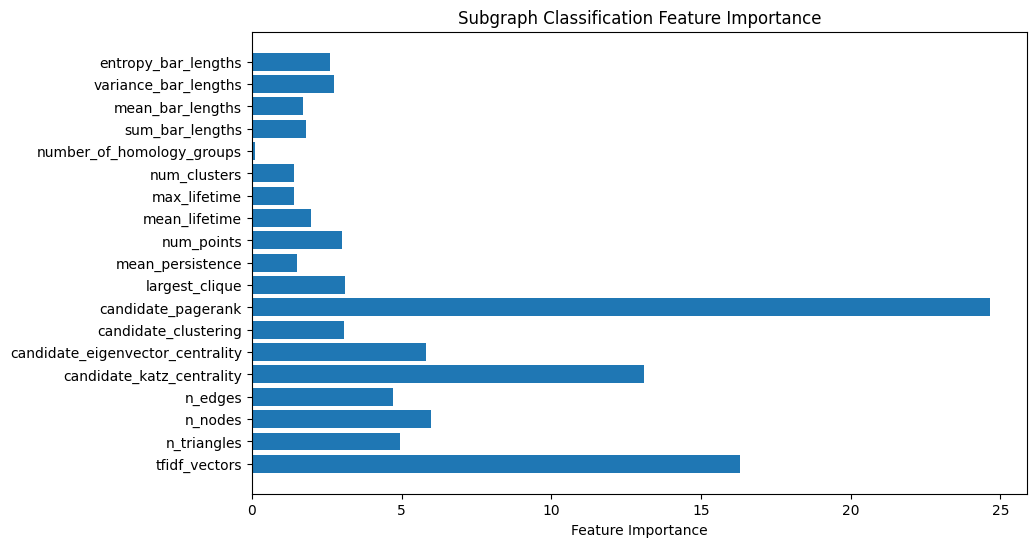

In [53]:
X_test_df = pd.DataFrame(X_test['tfidf_vectors'].to_list())
# Concatenate the new float columns to the dataframes
X_train_df_graph = pd.concat([X_train_df, df[float_cols]], axis=1)
X_val_df_graph = pd.concat([X_val_df, df_val[float_cols]], axis=1)
X_test_df_graph = pd.concat([X_test_df, df_test[float_cols]], axis=1)

# Select common features
common_features = set(X_train_df_graph.columns).intersection(X_val_df_graph.columns).intersection(X_test_df_graph.columns)
X_train_common = X_train_df_graph[list(common_features)]
X_val_common = X_val_df_graph[list(common_features)]
X_test_common = X_test_df_graph[list(common_features)]

# Convert back to numpy arrays
X_train_np = X_train_common.values
X_val_np = X_val_common.values
X_test_np = X_test_df_graph.values

# Initialize model with cat_vars
rf = CatBoostClassifier(
                   loss_function="Logloss",
                   eval_metric="AUC",
                   class_weights=class_weights,
                   iterations=2000,
                   l2_leaf_reg=5,
                   early_stopping_rounds=50
                   )

# Fit & Predict
rf.fit(X_train_np, y_train.values, plot=True, eval_set=(X_val_np, y_val.values))

y_pred_proba = rf.predict_proba(X_test_np)[:, 1]  # Probability of positive class

y_pred = rf.predict(X_test_np)

# Calculate metrics
f1 = f1_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("F1 score: {:.3f}".format(f1))
print("Balanced accuracy: {:.3f}".format(balanced_accuracy))
print("Accuracy score: {:.3f}".format(accuracy))
print("Predicted probabilities:")
print(y_pred_proba)